In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import joblib
from pathlib import Path
import pickle

In [44]:
from models import Ridge
from gp_models import SVGPModel

In [33]:
df_data = pd.read_csv('../out/ensemble-multidomain/phase1- /.csv', index_col=0)
column_names = df_data.columns.values
column_names

array(['pred-ssl_mos', 'pred-ridge-w2v_small', 'pred-ridge-w2v_large',
       'pred-ridge-hubert_base', 'pred-ridge-hubert_large',
       'pred-ridge-wavlm_base', 'pred-ridge-wavlm_large',
       'pred-linear_svr-w2v_small', 'pred-linear_svr-w2v_large',
       'pred-linear_svr-hubert_base', 'pred-linear_svr-hubert_large',
       'pred-linear_svr-wavlm_base', 'pred-linear_svr-wavlm_large',
       'pred-kernel_svr-w2v_small', 'pred-kernel_svr-w2v_large',
       'pred-kernel_svr-hubert_base', 'pred-kernel_svr-hubert_large',
       'pred-kernel_svr-wavlm_base', 'pred-kernel_svr-wavlm_large',
       'pred-lightgbm-w2v_small', 'pred-lightgbm-w2v_large',
       'pred-lightgbm-hubert_base', 'pred-lightgbm-hubert_large',
       'pred-lightgbm-wavlm_base', 'pred-lightgbm-wavlm_large',
       'mean-svgp-w2v_small', 'lower-svgp-w2v_small',
       'upper-svgp-w2v_small', 'mean-svgp-w2v_large',
       'lower-svgp-w2v_large', 'upper-svgp-w2v_large',
       'mean-svgp-hubert_base', 'lower-svgp-hubert_

In [6]:
ridge_model = joblib.load('../out/ensemble/phase1-main/stage2/ridge/0/model.joblib')
ridge_model

Ridge()

In [34]:
df_weight = pd.Series(dict(zip(column_names, ridge_model.coef_)))


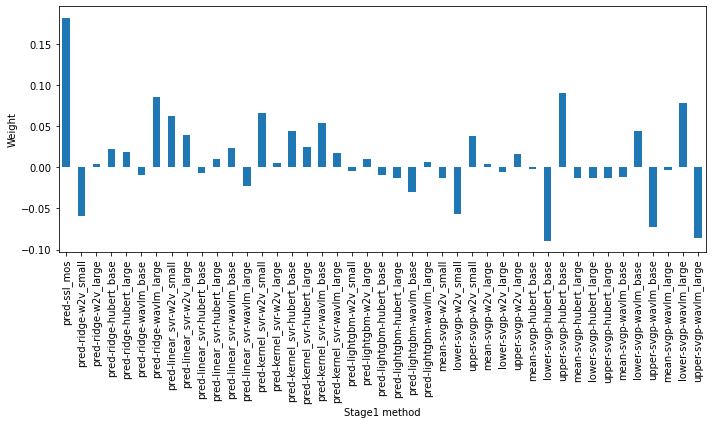

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_weight.plot.bar(ax=ax)
ax.set_ylabel('Weight')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/ridge_coef.pdf')

In [28]:
# !mkdir -p fig

In [40]:
initial_inducing = torch.from_numpy(np.empty((1024, len(column_names)), dtype=np.float32))
initial_inducing.size()

torch.Size([1024, 43])

In [45]:
pt_path = '../out/ensemble/phase1-main/stage2/svgp/0/model.pt'
gpr = SVGPModel(initial_inducing=initial_inducing, initial_lengthscale=1.0)
gpr.load_state_dict(torch.load(pt_path, map_location='cpu'))
gpr

SVGPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [51]:
lengthscale = gpr.covar_module.base_kernel.lengthscale.detach().numpy().ravel()
lengthscale

array([ 4.013196, 49.135426, 14.755179, 34.71999 , 28.09525 , 37.17488 ,
        9.062828, 20.490202, 13.48504 , 54.89949 , 24.684301, 28.47347 ,
       50.448124,  7.510106, 44.72974 , 12.805879, 21.234383,  9.331994,
       14.817871, 37.615864, 46.22099 , 46.004242, 29.292128, 10.089004,
       61.311295, 30.363464,  7.827811, 10.573437, 30.013273, 27.37951 ,
       41.920803, 37.563824, 43.904602, 19.565403, 29.833523, 29.737118,
       35.533993, 25.284203,  8.109434,  5.085182, 45.227283, 16.909266,
       14.388598], dtype=float32)

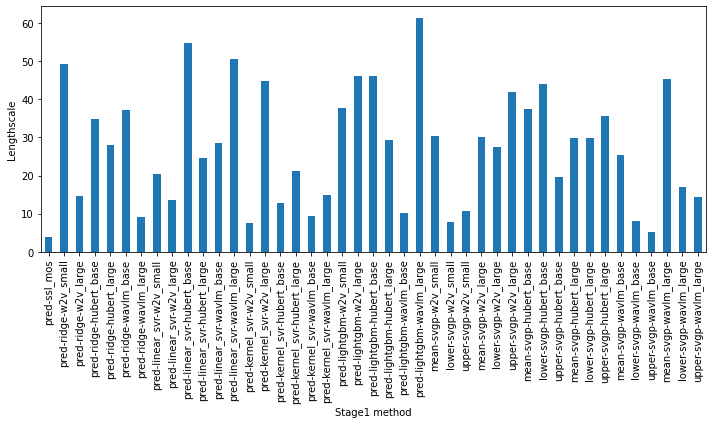

In [52]:
df_lengthscale = pd.Series(dict(zip(column_names, lengthscale)))
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_lengthscale.plot.bar(ax=ax)
ax.set_ylabel('Lengthscale')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/svgp_lengthscale.pdf')

In [55]:
lgb_path = '../out/ensemble/phase1-main/stage2/lightgbm/0/model.pkl'
lgb = pickle.load(open(lgb_path, 'rb'))
lgb.feature_importance()

array([77, 14, 33, 13, 18, 13, 30, 19, 17, 12, 20, 15, 24, 42, 16, 21, 18,
       24, 21, 27, 15, 13, 12, 31, 16,  4, 18,  6, 11, 14, 12,  6, 12, 17,
       15, 21,  6,  8, 17, 13, 14, 17,  8], dtype=int32)

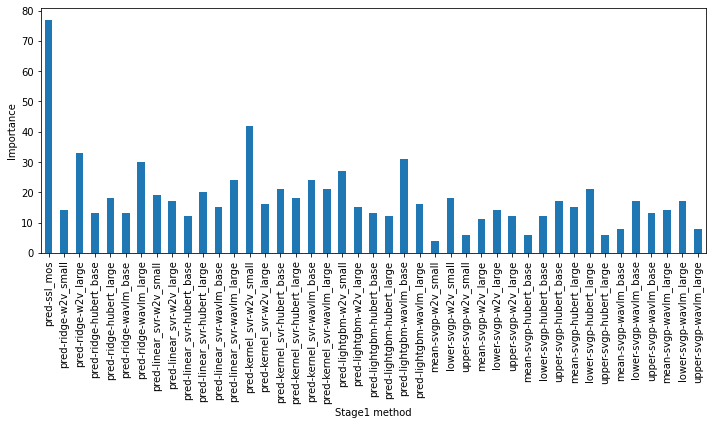

In [57]:
df_importance = pd.Series(dict(zip(column_names, lgb.feature_importance())))
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_importance.plot.bar(ax=ax)
ax.set_ylabel('Importance')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/lightgbm_importance.pdf')